In [1]:
from numba.cuda.cudadrv import enums
from numba import cuda

In [2]:
!wget -O img.jpeg https://file.io.vn/W3MG0J

--2025-10-10 15:58:52--  https://file.io.vn/W3MG0J
Resolving file.io.vn (file.io.vn)... 157.10.45.101
Connecting to file.io.vn (file.io.vn)|157.10.45.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://my.microsoftpersonalcontent.com/personal/de4e2fbd58f4f53b/_layouts/15/download.aspx?UniqueId=2375f846-15de-42e9-87e9-c31e5bebf509&Translate=false&tempauth=v1e.eyJzaXRlaWQiOiJiMWVkOTQ5Mi0wMDA3LTRhNWEtYjJmOC05MzA4OWQ4YzgwMmQiLCJhcHBfZGlzcGxheW5hbWUiOiJpaW5kZXgiLCJhcHBpZCI6ImQ4NWE5YTNhLTM4MzktNDkzMC05ZjE0LTgxOGEyZDQ0OWE0ZCIsImF1ZCI6IjAwMDAwMDAzLTAwMDAtMGZmMS1jZTAwLTAwMDAwMDAwMDAwMC9teS5taWNyb3NvZnRwZXJzb25hbGNvbnRlbnQuY29tQDkxODgwNDBkLTZjNjctNGM1Yi1iMTEyLTM2YTMwNGI2NmRhZCIsImV4cCI6IjE3NjAxMTU1MzQifQ.-iqYGN9J2Jx8_zuxsVo4VGj9U2A9jqLEf8NjTE_PpeFkXbi1cH9TYkYhsCBspuCD2mpASBy2ZHwqz3MlX6BEa4cXuRYdpsc_W-XwYbOG55w52uar1NM1SaRaCQwKek7ZPvpOtDP0UYwsJPfmkuXbC8ucydXk8FkPHOpLq0V37zftL4hB4mFdxdbnvsg1ZkxSz2_4EJL9VTsFYjk3QDT6IiyTCN0gxXMAv1Tci1ZiPaG1LMd68gdXx-slezrwSxEnA

In [3]:
# from matplotlib import pyplot
import matplotlib

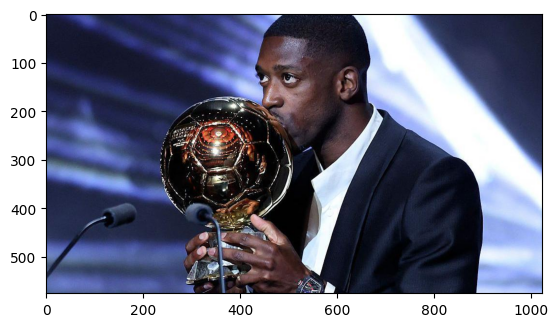

In [4]:
#Load the image
img = matplotlib.pyplot.imread('img.jpeg')

matplotlib.pyplot.imshow(img)

In [5]:
height, width, channels = img.shape
rgb_1d = img.reshape(height * width * 3)
rgb_2d = img.reshape(height, width, 3)

In [6]:
import time

In [7]:
from numba import jit, int32, float32
import numpy as np
from numba import config
import matplotlib.pyplot as plt
config.CUDA_ENABLE_PYNVJITLINK = 1
import math

In [8]:
@cuda.jit
def grayscale_2d(src, dst):
    x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    y = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    if x < src.shape[1] and y < src.shape[0]:
        r = src[y, x, 0]
        g = src[y, x, 1]
        b = src[y, x, 2]

        gray = np.uint8((r + g + b) / 3)
        dst[y, x] = gray

In [12]:
@cuda.jit
def binarize_image(src, dst, threshold):
    x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    y = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    if x < src.shape[1] and y < src.shape[0]:
        intensity = src[y, x]
        if intensity < np.uint8(threshold):
            dst[y, x] = 0
        else:
            dst[y, x] = 255

In [13]:
# mem allocate
gray_2d_empty = np.empty((height, width), dtype=np.uint8)
devSrc = cuda.to_device(rgb_2d)
devDst = cuda.to_device(gray_2d_empty)

threads_per_block = (16, 16)
blocks_per_grid_x = (width + threads_per_block[0] - 1) // threads_per_block[0]
blocks_per_grid_y = (height + threads_per_block[1] - 1) // threads_per_block[1]
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

threshold = 0.5
kernel_threshold = threshold * 255

grayscale_2d[blocks_per_grid, threads_per_block](devSrc, devDst)
cuda.synchronize()
grayscale = devDst.copy_to_host()


In [14]:
binary_result = np.empty_like(grayscale)
binary_result_shared = np.empty_like(grayscale)

dev_src = cuda.to_device(grayscale)
dev_dst = cuda.to_device(binary_result)
dev_dst_shared = cuda.to_device(binary_result_shared)

kernel_threshold = threshold * 255

# warm-up first
binarize_image[blocks_per_grid, threads_per_block](
    dev_src, dev_dst, kernel_threshold
)
cuda.synchronize()

start_time = time.time()
binarize_image[blocks_per_grid, threads_per_block](
    dev_src, dev_dst, kernel_threshold
)
cuda.synchronize()
end_time = time.time()

result_no_shared = dev_dst.copy_to_host()
time_no_shared = end_time - start_time
print(f"\nTime without shared memory: {time_no_shared:.6f} seconds")


Time without shared memory: 0.000301 seconds


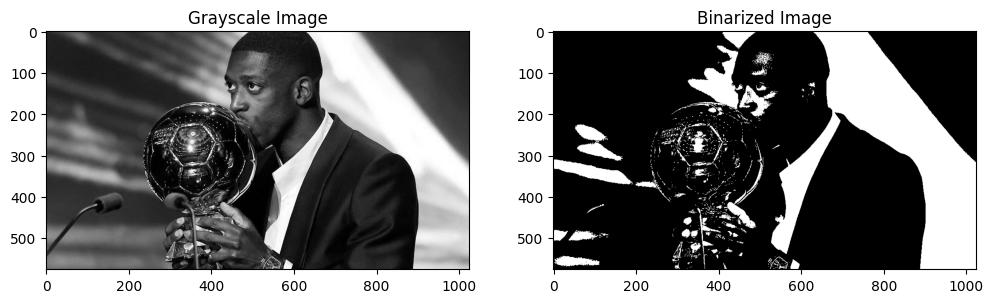

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(grayscale, cmap='gray')
axs[0].set_title('Grayscale Image')
axs[1].imshow(result_no_shared, cmap='gray')
axs[1].set_title('Binarized Image')
plt.show()